# Corporate Sustainability

## 0 - Imports and Dependencies

### Dependencies

To run this notebook, please make sure you have the following packages installed:

- `pandas`: For handling data in dataframes.
- `datasets`: For loading datasets.
- `spacy`: For natural language processing.
- `scikit-learn`: For machine learning algorithms, vectorization, model evaluation, and pipelines.
- `wordcloud`: For creating a visual interpretation of text analytics.
- `nlpaug`: For data augmenting

You can install these packages using the following command:

```bash
pip install pandas datasets spacy scikit-learn wordcloud nlpaug

```
or using conda:
```bash
conda install pandas datasets spacy scikit-learn wordcloud nlpaug

python -m spacy download en_core_web_sm


In [70]:
# General imports
from sklearn.metrics import roc_curve, roc_auc_score, auc
import json
import random
from collections import Counter

import matplotlib.pyplot as plt
import nlpaug.augmenter.word as naw
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import spacy
import warnings
from datasets import load_dataset
from gensim.models import Word2Vec
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_extraction.text import (CountVectorizer,
                                             HashingVectorizer,
                                             TfidfVectorizer)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report,
                             precision_recall_fscore_support, confusion_matrix)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from textblob import TextBlob
from wordcloud import WordCloud

# Ignore warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)


## 1 - Data Loading

In [12]:
# Load data
dataset = load_dataset('climatebert/environmental_claims')

Found cached dataset parquet (/Users/pcw/.cache/huggingface/datasets/climatebert___parquet/climatebert--environmental_claims-3af61fabe0b07b9a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/3 [00:00<?, ?it/s]

In [13]:
# Display to show how the format of the dataset looks like
dataset

DatasetDict({
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 300
    })
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2400
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 300
    })
})

In [14]:
# Creating a dataframe for each split

env_claim_train = pd.DataFrame(dataset['train'])
env_claim_test = pd.DataFrame(dataset['test'])
env_claim_val = pd.DataFrame(dataset['validation'])


In [15]:
# Define color codes
class Colors:
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    ENDC = '\033[0m'

# Displaying the characteristics of the data
print(Colors.OKGREEN + "Training data" + Colors.ENDC)
print(f"The shape of the training data is: {env_claim_train.shape}")
display(env_claim_train.head())
display(env_claim_train.label.value_counts())

print(Colors.OKBLUE + "\nTest data" + Colors.ENDC)
print(f"The shape of the test data is: {env_claim_test.shape}")
display(env_claim_test.head())
display(env_claim_test.label.value_counts())

print(Colors.OKCYAN + "\nValidation data" + Colors.ENDC)
print(f"The shape of the validation data is: {env_claim_val.shape}")
display(env_claim_val.head())
display(env_claim_val.label.value_counts())

Training data
The shape of the training data is: (2400, 2)


,text,label
0,It will enable E.ON to acquire and leverage a ...,0
1,And that's honestly most markets in the U.S. S...,0
2,A key pillar of our strategy is to continue to...,0
3,The goal to reduce relative GHG emissions by 2...,1
4,"As you know, we drove about $75 million of cos...",0


0    1858
1     542
Name: label, dtype: int64


Test data
The shape of the test data is: (300, 2)


,text,label
0,I don't know what the economic bumps are going...,0
1,2 oven that will almost deliver as good as a p...,0
2,"And so certainly, we have a lot of cost saving...",0
3,So it's only in back half as we continue our e...,0
4,We have worked hard to make real energy effici...,0


0    236
1     64
Name: label, dtype: int64


Validation data
The shape of the validation data is: (300, 2)


,text,label
0,The method used for these impairment tests is ...,0
1,We're making the transition from strictly gas ...,0
2,"At the same time, desks are being equipped wit...",1
3,In addition to the goal of having net zero emi...,1
4,The exchange rates used for the consolidated i...,0


0    236
1     64
Name: label, dtype: int64

## 2 - EDA

In [16]:
# Concatenate sets 
claim_dataset = pd.concat([env_claim_train, env_claim_test, env_claim_val], ignore_index = True)
print("Number of claims in the dataset:", claim_dataset.shape[0])    # observations
print("Number of variables in the dataset:", claim_dataset.shape[1]) # variables 

Number of claims in the dataset: 3000
Number of variables in the dataset: 2


In [17]:
# NaNs 
print("Number of NaNs:")
display(claim_dataset.isna().sum())

# Duplicates
print("Number of duplicates:")
display(claim_dataset.duplicated().sum())

# Variable types
print("Variable types:")
claim_dataset.dtypes

Number of NaNs:


text     0
label    0
dtype: int64

Number of duplicates:


0

Variable types:


text     object
label     int64
dtype: object

### Word Count by Claim

The average number of words in each claim is equal to: 24.0 words.


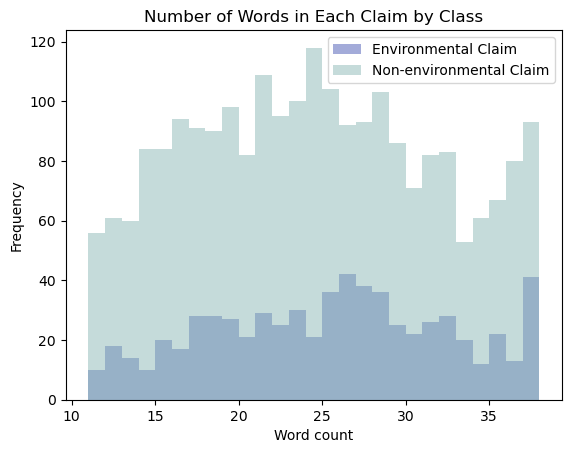

In [18]:
# Word count
claim_dataset["word count"] = claim_dataset["text"].apply(lambda x: len(x.split()))
print("The average number of words in each claim is equal to:", round(claim_dataset["word count"].mean(),0), "words.")

# Graphical representation by class
class_1_counts = claim_dataset[claim_dataset["label"] == 1]["word count"]
class_2_counts = claim_dataset[claim_dataset["label"] == 0]["word count"]

plt.hist(class_1_counts, bins = range(11, 39), alpha = 0.5, label = "Environmental Claim", color = "#4958B5")
plt.hist(class_2_counts, bins = range(11, 39), alpha = 0.5, label = "Non-environmental Claim", color = "#8DB8B7")
plt.xlabel("Word count")
plt.ylabel("Frequency")
plt.title("Number of Words in Each Claim by Class")
plt.legend(loc = "upper right")
plt.show()

### Claim Cleaning

In [19]:
# Load English language model
sp = spacy.load('en_core_web_sm')

# Apply the Spacy sp function to each row of the 'text' column
claim_dataset["spacy object"] = claim_dataset["text"].apply(sp)

# Filter stopwords, punctuation and spaces
def filter_tokens(token):
    return not token.is_stop and not token.is_punct and not token.is_space

# Remove stopwords, punctuation, and whitespace from each Spacy object
claim_dataset["filtered tokens"] = claim_dataset["spacy object"].apply(lambda doc: [token.text for token in doc if filter_tokens(token)])

print("This is the first sentence before filtering:", claim_dataset.iloc[0,0])
print("\nThis is the first sentence after filtering:", claim_dataset.iloc[0,4])

# Calculating new average value of words per claim
number_words = [len(x) for x in claim_dataset["filtered tokens"]]
print("\nThe average number of words per claim is now:", round(np.mean(number_words),0))
display(claim_dataset.head())

This is the first sentence before filtering: It will enable E.ON to acquire and leverage a comprehensive understanding of the transfor- mation of the energy system and the interplay between the individual submarkets in regional and local energy supply sys- tems.

This is the first sentence after filtering: ['enable', 'E.ON', 'acquire', 'leverage', 'comprehensive', 'understanding', 'transfor-', 'mation', 'energy', 'system', 'interplay', 'individual', 'submarkets', 'regional', 'local', 'energy', 'supply', 'sys-', 'tems']

The average number of words per claim is now: 13.0


,text,label,word count,spacy object,filtered tokens
0,It will enable E.ON to acquire and leverage a ...,0,34,"(It, will, enable, E.ON, to, acquire, and, lev...","[enable, E.ON, acquire, leverage, comprehensiv..."
1,And that's honestly most markets in the U.S. S...,0,37,"(And, that, 's, honestly, most, markets, in, t...","[honestly, markets, U.S., fact, think, opportu..."
2,A key pillar of our strategy is to continue to...,0,39,"(A, key, pillar, of, our, strategy, is, to, co...","[key, pillar, strategy, continue, adapt, busin..."
3,The goal to reduce relative GHG emissions by 2...,1,15,"(The, goal, to, reduce, relative, GHG, emissio...","[goal, reduce, relative, GHG, emissions, 20, 2..."
4,"As you know, we drove about $75 million of cos...",0,17,"(As, you, know, ,, we, drove, about, $, 75, mi...","[know, drove, $, 75, million, cost, synergies,..."


### Environmental Claims versus Non-Environmental Claims

In [20]:
# Mean 
print("Average number of words per claim by class:")
display(claim_dataset.groupby("label").mean().round())

# Median
print("\nMedian number of words per claim by class:")
display(claim_dataset.groupby("label").median())

Average number of words per claim by class:


,word count
label,
0,24.0
1,25.0



Median number of words per claim by class:


,word count
label,
0,24.0
1,26.0


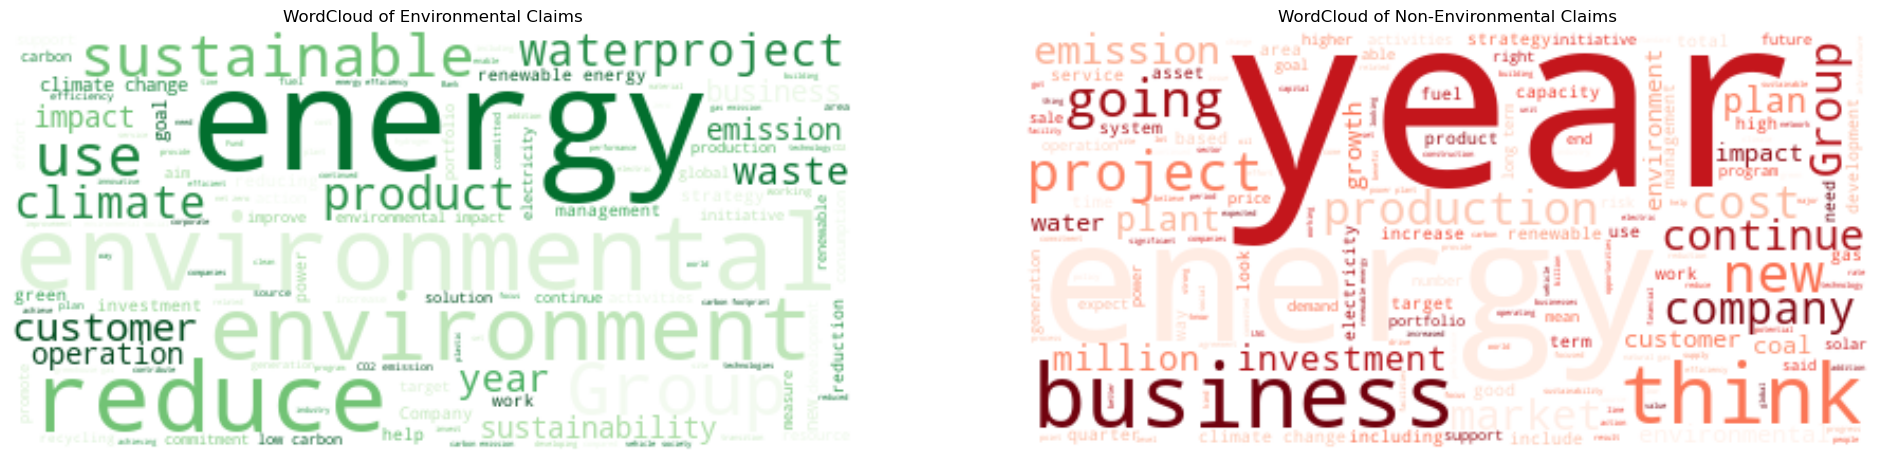

In [21]:
# WordCloud hue by class label

# Join the strings in each list into a single string
claim_dataset["joined tokens"] = claim_dataset["filtered tokens"].apply(lambda tokens: ' '.join(tokens))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6))

# For Environmental Claims
text = " ".join(word for word in claim_dataset[claim_dataset["label"]==1]["joined tokens"])
wordcloud = WordCloud( background_color = "white", colormap = "Greens").generate(text)

ax1.imshow(wordcloud, interpolation = "bilinear")
ax1.set(title = "WordCloud of Environmental Claims")
ax1.axis("off")

# For Non-Environmental Claims
text = " ".join(word for word in claim_dataset[claim_dataset["label"]==0]["joined tokens"])
wordcloud = WordCloud(background_color = "white", colormap = "Reds").generate(text)

ax2.imshow(wordcloud, interpolation='bilinear')
ax2.set(title = "WordCloud of Non-Environmental Claims")
ax2.axis("off")
plt.show()

In [22]:
# Most frequent words for environmental claims
top = Counter([item for sublist in claim_dataset["joined tokens"][claim_dataset["label"]==1] for item in str(sublist).split()])
temp = pd.DataFrame(top.most_common(10))
temp.columns = ["Common Words", "Count"]
print("Most frequent words for environmental claims:")
display(temp.style.background_gradient(cmap = "Greens"))

# Most frequent words for non-environmental claims
top = Counter([item for sublist in claim_dataset["joined tokens"][claim_dataset["label"]==0] for item in str(sublist).split()])
temp = pd.DataFrame(top.most_common(10))
temp.columns = ["Common Words", "Count"]
print("\nMost frequent words for non-environmental claims:")
display(temp.style.background_gradient(cmap = "Reds"))

Most frequent words for environmental claims:


,Common Words,Count
0,energy,181
1,environmental,145
2,carbon,109
3,emissions,105
4,reduce,81
5,renewable,63
6,impact,62
7,climate,61
8,sustainable,54
9,power,54



Most frequent words for non-environmental claims:


,Common Words,Count
0,energy,258
1,year,236
2,emissions,150
3,business,148
4,going,133
5,gas,132
6,million,131
7,think,130
8,new,117
9,cost,116


### 2.2 Populating with more environmental claims

We have used ChatGPT 3 and 4 to generate different environmental claims. These can be found in the `env_claims_gpt3.json` and `env_claims_gpt4.json` in the `./data` folder.

We will append these statements to the ones we already have, and later investigate whether these can improve our performance.

In [23]:
# Importing the env claims from env_claims_gpt4.json

claims_gpt4 = []
# Load the env_claims_gpt3.json file
with open('./data/env_claims_gpt4.json') as json_file:
	data = json.load(json_file)

	for i in range(len(data['claims'])):
		claims_gpt4.append(data['claims'][i]['claim'])

In [24]:
claims_gpt3 = []
# Load the env_claims_gpt3.json file
with open('./data/env_claims_gpt3.json') as json_file:
	data = json.load(json_file)

	for i in range(len(data['claims'])):
		claims_gpt3.append(data['claims'][i]['claim'])


In [25]:
# Number of claims
print("Number of claims in the dataset (GPT4):", len(claims_gpt4))    # observations
print("Number of claims in the dataset (GPT3):", len(claims_gpt3))    # observations
print("Total number of claims in the dataset:", len(claims_gpt4)+len(claims_gpt3))    # observations

Number of claims in the dataset (GPT4): 148
Number of claims in the dataset (GPT3): 103
Total number of claims in the dataset: 251


In [26]:
# Converting the list to a dataframe

claims_gpt4_df = pd.DataFrame(claims_gpt4, columns = ['text'])
claims_gpt3_df = pd.DataFrame(claims_gpt3, columns = ['text'])

# Adding the label column
claims_gpt4_df['label'] = 1
claims_gpt3_df['label'] = 1

# Concatenating the two dataframes
claims_gpt_df = pd.concat([claims_gpt4_df, claims_gpt3_df], ignore_index=True)
display(claims_gpt_df)

,text,label
0,We aim to achieve net-zero carbon emissions by...,1
1,Our products are made from 100% recycled mater...,1
2,We use renewable energy sources to power our p...,1
3,We have reduced our water usage by 25% over th...,1
4,Our goal is to plant a million trees by 2025.,1
...,...,...
246,Our company promotes sustainable farming pract...,1
247,"We invest in innovative clean technologies, su...",1
248,Our company supports initiatives that promote ...,1
249,We have implemented a sustainable waste manage...,1


### Studying Energy Claims using N-Grams

In [27]:
# Still need to finish this 

In [28]:
# Subsample of claims with word "energy" inside
energy_df = claim_dataset[claim_dataset["joined tokens"].str.contains("energy")]
print("In the original dataset, there are", len(energy_df), "claims containing the word 'energy'.")

# Subsample of claims with word "energy" inside and label == 1
energy_df_1 = energy_df[energy_df["label"] == 1]

# Subsample of claims with word "energy" inside and label == 0
energy_df_0 = energy_df[energy_df["label"] == 0]

In the original dataset, there are 370 claims containing the word 'energy'.


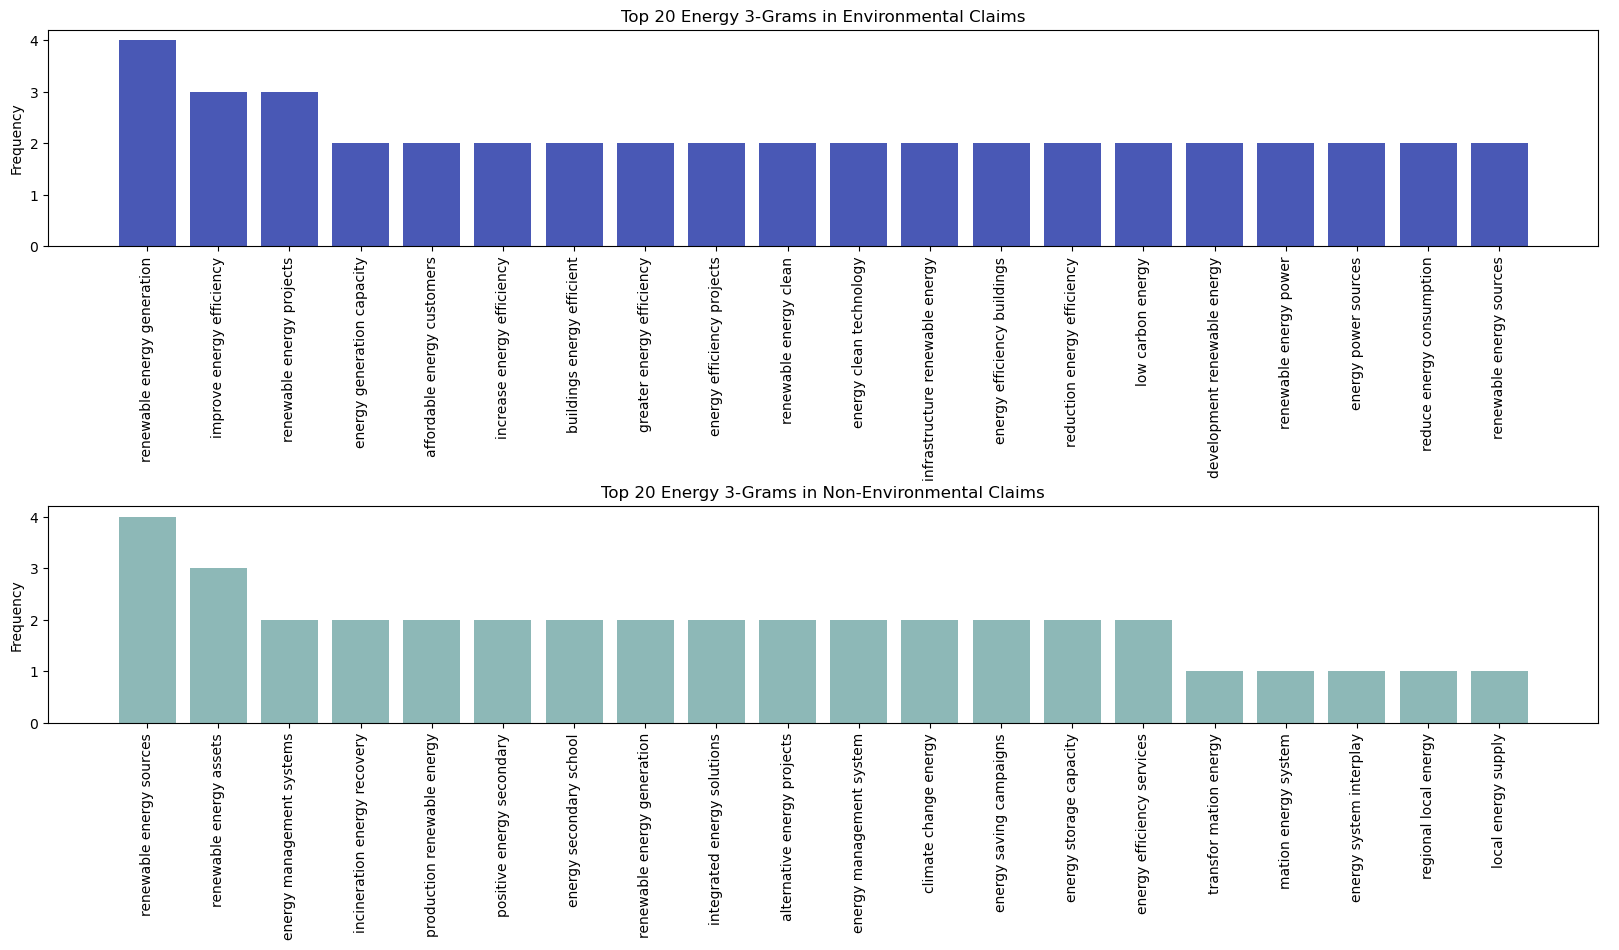

In [29]:
# Function calculating most frequent N-Grams given corpus, n-grams

def top_n_ngram(energy_corpus, ngram = 3):
    vec = CountVectorizer(ngram_range = (ngram,ngram)).fit(energy_corpus)
    words_bag = vec.transform(energy_corpus)  # Have the count of  all the words for each claim
    sum_words = words_bag.sum(axis = 0)       # Calculates the count of all the word in the whole claim
    words_freq = [(word,sum_words[0,idx]) for word,idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq,key = lambda x:x[1],reverse = True)
    return words_freq

# Call function on both datasets 
pop_words_1 = top_n_ngram(energy_df_1["joined tokens"], 3)  
pop_words_0 = top_n_ngram(energy_df_0["joined tokens"], 3)  

# Select top 20 N-Grams having 'energy' in text 
pop_energy_1 = [t for t in pop_words_1 if "energy" in t[0]]
pop_energy_1 = pop_energy_1[:20]
pop_energy_0 = [t for t in pop_words_0 if "energy" in t[0]]
pop_energy_0 = pop_energy_0[:20]

# Graphical representation

# Extract x and y values from each list
x1, y1 = zip(*pop_energy_1)
x2, y2 = zip(*pop_energy_0)

# Set up the figure and axes
fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (20,9))
fig.subplots_adjust(hspace = 1.2)

# Create the first bar plot on ax1
ax1.bar(x1, y1, color = "#4958B5")
ax1.set_ylabel("Frequency")
ax1.set_xticks(range(len(x1)))
ax1.set_xticklabels(x1, rotation = 90)
ax1.set_title("Top 20 Energy 3-Grams in Environmental Claims")

# Create the second bar plot on ax2
ax2.bar(x2, y2, color = "#8DB8B7")
ax2.set_ylabel("Frequency")
ax2.set_xticks(range(len(x2)))
ax2.set_xticklabels(x2, rotation = 90)
ax2.set_title("Top 20 Energy 3-Grams in Non-Environmental Claims")

# Add x-axis label
fig.add_subplot(111, frameon = False)
plt.tick_params(labelcolor = "none", top = False, bottom = False, left = False, right = False)

# Show the plot
plt.show()

In [30]:
# Notes for the team: I did the study of the previous section to understand why energy is the most frequent word
# in both claims (environmental vs. non-environmental). With the 3 n-grams I wanted to see whether I could
# find a difference in how they use the word "energy" but nothing strikes me actually. If you have any idea on 
# how I could further explore it or explain the difference I'd be happy to listed at your suggestions 

# Please let me know if you would add anything else to the EDA

### Declaring the train and test datasets for X and y

In [31]:
X_train, y_train = env_claim_train['text'], env_claim_train['label']
X_test, y_test = env_claim_test['text'], env_claim_test['label']
X_val, y_val = env_claim_val['text'], env_claim_test['label']

### Exploring Labelled Data and Defining Base Rate

TODO: Include gpt generated claims and show graph for both dataframes and label categories

Train set per class:


0    1858
1     542
Name: label, dtype: int64


Test set per class:


0    236
1     64
Name: label, dtype: int64


Validation set per class:


0    236
1     64
Name: label, dtype: int64

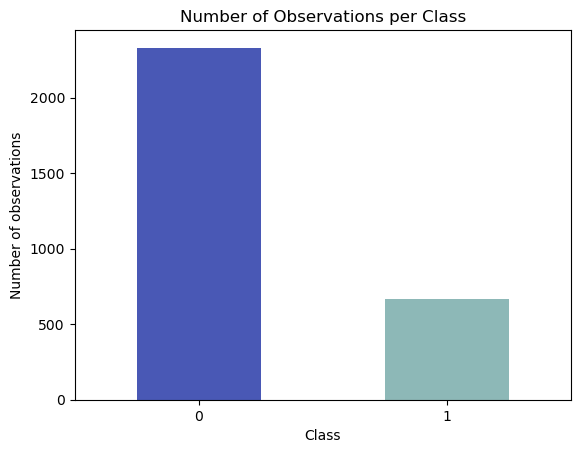

In [32]:
# Train Set
print(Colors.OKGREEN + "Train set per class:" + Colors.ENDC)
display(y_train.value_counts())
      

# Test Set 
print(Colors.OKBLUE + "\nTest set per class:" + Colors.ENDC)
display(y_test.value_counts())

# Validation Set
print(Colors.OKCYAN + "\nValidation set per class:" + Colors.ENDC)
display(y_val.value_counts())


# Graphical representation
outcome_variable = pd.concat([y_train, y_test, y_val])
outcome_variable.value_counts().plot.bar(color = ["#4958B5", "#8DB8B7"], grid = False)
plt.ylabel("Number of observations")
plt.xlabel("Class")
plt.title("Number of Observations per Class")
plt.xticks(rotation = 0)
plt.show()

In [33]:
# Base rate
base_rate = round(len(outcome_variable[outcome_variable == 0]) / len (outcome_variable), 4)
print(f'The base rate is: {base_rate*100:0.2f}%')

The base rate is: 77.67%


### Balancing Labelled Data

In [34]:
# Get indices of "0" outcomes in the training set
train_zeros_idx = pd.Series(y_train[y_train == 0].index)

# Randomly select a balanced number of "0" outcomes
train_zeros_sample_idx = train_zeros_idx.sample(n = sum(y_train == 1), random_state = 7)

# Use the sampled indices to get the final balanced training set
X_train_bal = pd.concat([X_train[y_train == 1], X_train[train_zeros_sample_idx]])
y_train_bal = pd.concat([y_train[y_train == 1], y_train[train_zeros_sample_idx]])


# Get indices of "0" outcomes in the test set
test_zeros_idx = pd.Series(y_test[y_test == 0].index)

# Randomly select a balanced number of "0" outcomes
test_zeros_sample_idx = test_zeros_idx.sample(n = sum(y_test == 1), random_state = 7)

# Use the sampled indices to get the final balanced test set
X_test_bal = pd.concat([X_test[y_test == 1], X_test[test_zeros_sample_idx]])
y_test_bal = pd.concat([y_test[y_test == 1], y_test[test_zeros_sample_idx]])

# Get indices of "0" outcomes in the validation set
val_zeros_idx = pd.Series(y_val[y_val == 0].index)

# Randomly select a balanced number of "0" outcomes
val_zeros_sample_idx = val_zeros_idx.sample(n = sum(y_val == 1), random_state = 7)

# Use the sampled indices to get the final balanced validation set
X_val_bal = pd.concat([X_val[y_val == 1], X_val[val_zeros_sample_idx]])
y_val_bal = pd.concat([y_val[y_val == 1], y_val[val_zeros_sample_idx]])

In [35]:
print("Number of observations per class after balancing the classes:\n")

# Train Set
print(Colors.OKGREEN + "Train set per class" + Colors.ENDC)
display(y_train_bal.value_counts())
      

# Test Set 
print(Colors.OKBLUE + "\nTest set per class" + Colors.ENDC)
display(y_test_bal.value_counts())

# Validation Set
print(Colors.OKCYAN + "\nValidation set per class" + Colors.ENDC)
display(y_val_bal.value_counts())

print("\nThe new balanced dataset contains", len(y_train_bal + y_test_bal + y_val_bal) , "observations.")

Number of observations per class after balancing the classes:

Train set per class


1    542
0    542
Name: label, dtype: int64


Test set per class


1    64
0    64
Name: label, dtype: int64


Validation set per class


1    64
0    64
Name: label, dtype: int64


The new balanced dataset contains 1152 observations.


## 3 - Training and running ML model

### 3.1 Text Classification using TF-IDF Vectorization and Logistic Regression

In [75]:
# Create a spaCy tokenizer
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def spacy_tokenizer(text):
    return [tok.lemma_.lower().strip() for tok in nlp(text) if tok.is_alpha and not tok.is_stop]

def classification_report_prettify(report):
    ''' 
    Creates a df from the precision_recall_fscore_support function
    Input: model performance metrics
    '''
    out_df = pd.DataFrame(report).transpose()
    out_df.columns = ['precision', 'recall', 'f1-score', 'support']
    avg_tot = (out_df.apply(lambda x: round(x.mean(), 2) if x.name!="support" else  round(x.sum(), 2)).to_frame().T)
    avg_tot.index = ["avg/total"]
    out_df = pd.concat([out_df, avg_tot])
    out_df['support'] = out_df['support'].apply(lambda x: int(x))
    return out_df


def plot_roc_curve(y_true, y_score):
    '''
    This function plots the ROC curve.
    '''
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes):
    '''
    This function prints and plots the confusion matrix.
    '''
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap="Blues", cbar=False)
    
    ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
           yticklabels=classes, title="Confusion matrix")
    plt.yticks(rotation=0)
    plt.show()


def evaluate_model(vectorizer, classifier, X_train, y_train, X_test, y_test, with_confusion_matrix=False):
    ''' 
    Function to evaluate the model performance
    Input: vectorizer, classifier, X_train, y_train, X_test, y_test
    Output: accuracy score and classification report
    '''
    # Create a pipeline with the vectorizer and classifier
    pipe = Pipeline([('vectorizer', vectorizer), ('classifier', classifier)])

    # Train the model
    pipe.fit(X_train, y_train)

    # Test the model
    y_pred = pipe.predict(X_test)

    y_score = pipe.predict_proba(X_test)[:,1]

    # Adding a title to the dataframe based on the model and vectorizer used
    title = str(classifier).split('(')[0] + ' with ' + str(vectorizer).split('(')[0]
    print("-" * len(title))
    print(Colors.OKGREEN + title + Colors.ENDC)
    print("-" * len(title))

    # Calculate accuracy and print the performance metrics
    display(classification_report_prettify(precision_recall_fscore_support(y_test, y_pred)))
    accuracy = accuracy_score(y_test, y_pred)   # Accuracy is the number of correct predictions divided by the total number of predictions
    print(Colors.OKBLUE + f'Accuracy: {accuracy*100:0.2f}%' + Colors.ENDC)    # Print the accuracy with 3 decimal points

    # Plot the confusion matrix
    if with_confusion_matrix:
        plot_confusion_matrix(y_test, y_pred, ['0', '1'])
        
    return y_pred, y_score


vectorizer = TfidfVectorizer(tokenizer=spacy_tokenizer, ngram_range=(1, 2), max_df=0.85, min_df=2)  # Define the vectorizer
clf = LogisticRegression(solver='liblinear')                                                        # Define the classifier

# Evaluate the model
y_pred_clf_tfidf, y_score_clf_tfidf = evaluate_model(vectorizer, clf, X_train, y_train, X_test, y_test)


---------------------------------------
LogisticRegression with TfidfVectorizer
---------------------------------------


,precision,recall,f1-score,support
0,0.826715,0.970339,0.892788,236
1,0.695652,0.250000,0.367816,64
avg/total,0.760000,0.610000,0.630000,300


Accuracy: 81.67%


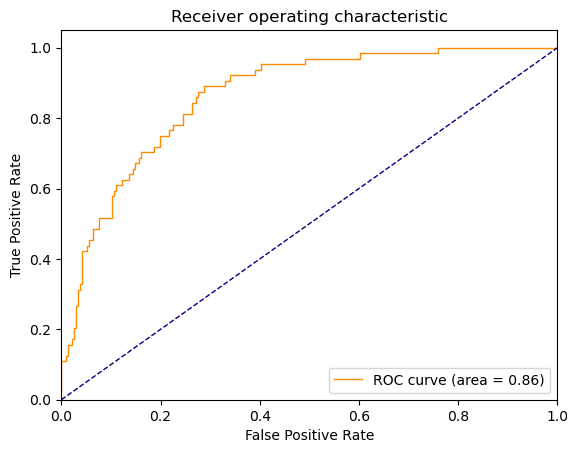

In [71]:
plot_roc_curve(y_pred_clf_tfidf, y_score_clf_tfidf)

### 3.2 TF-IDF Vectorization and Logistic Regression Fine Tuning Hyperparameters

In the initial model, we used a TF-IDF Vectorizer and a Logistic Regression classifier to predict whether a statement is an environmental claim or not. However, the model's performance can often be improved by tuning the hyperparameters of the vectorizer and the classifier.

Hyperparameters are parameters that are not learned from the data. They are set prior to the commencement of the learning process. For instance, in the case of TF-IDF Vectorizer, `ngram_range`, `max_df`, and `min_df` are hyperparameters. For the Logistic Regression classifier, `C`, which is the inverse of regularization strength, is a hyperparameter. 

Hyperparameter tuning involves selecting the combination of hyperparameters for a machine learning model that performs the best on a validation set.

#### Steps Taken for Hyperparameter Tuning

1. **Pipeline Creation**: We first created a pipeline that combines the vectorizer and the classifier. This allows us to jointly optimize the hyperparameters of both.

2. **Define Hyperparameters**: We then defined a list of hyperparameters to tune for both the vectorizer and the classifier. For the vectorizer, we decided to tune `ngram_range`, `max_df`, and `min_df`. For the classifier, we decided to tune `C`.

3. **Grid Search**: Next, we performed a grid search to find the combination of hyperparameters that results in the best cross-validated performance on the training data. Grid search works by training and evaluating a model for each combination of hyperparameters, and selecting the combination that performs best.

4. **Best Parameters**: After the grid search, we printed the combination of hyperparameters that performed the best.

5. **Evaluate the Model**: Finally, we used the best hyperparameters to create a new vectorizer and classifier, and evaluated the performance of the model on the test data.

This process allowed us to optimize the model's performance by finding the best hyperparameters. Note that the best hyperparameters are specific to the training data, and might not be the best for other datasets.

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters: {'classifier__C': 10, 'vectorizer__max_df': 0.85, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 2)}
---------------------------------------
LogisticRegression with TfidfVectorizer
---------------------------------------


,precision,recall,f1-score,support
0,0.882845,0.894068,0.888421,236
1,0.590164,0.562500,0.576000,64
avg/total,0.740000,0.730000,0.730000,300


Accuracy: 82.33%


<Figure size 100x100 with 0 Axes>

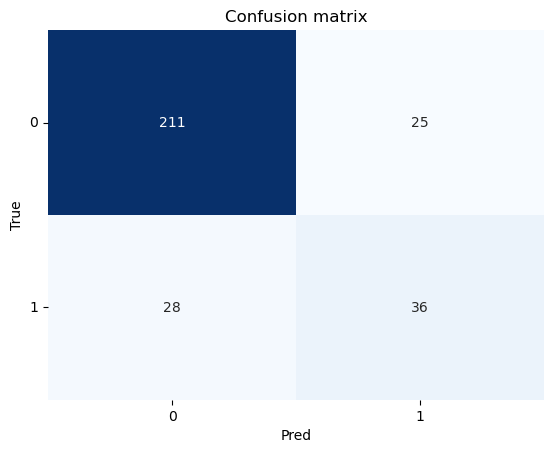

In [57]:
# Preprocess the data using the spaCy tokenizer
X_train_tokenized = [' '.join(spacy_tokenizer(text)) for text in X_train]   # Matching the GridSearchCV format
X_test_tokenized = [' '.join(spacy_tokenizer(text)) for text in X_test]     # Matching the GridSearchCV format

# Define a new hyperparameter tuning function that doesn't include the tokenizer
def hyperparameter_tuning(X_train, y_train):
    ''' 
    Function to perform hyperparameter tuning
    Input: X_train, y_train
    Output: best_params_
    '''
    # Create a pipeline with the vectorizer and classifier
    pipe = Pipeline([('vectorizer', TfidfVectorizer()), 
                     ('classifier', LogisticRegression(solver='liblinear'))])

    # Define the hyperparameters to tune
    params = {
        'vectorizer__ngram_range': [(1, 1), (1, 2)],
        'vectorizer__max_df': [0.85, 0.9, 0.95],
        'vectorizer__min_df': [1, 2, 3],
        'classifier__C': [0.1, 1, 10],
    }

    # Perform grid search
    grid_search = GridSearchCV(pipe, param_grid=params, cv=5, verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print("Best parameters:", grid_search.best_params_)

    return grid_search.best_params_

# Perform hyperparameter tuning on the tokenized data
best_params = hyperparameter_tuning(X_train_tokenized, y_train)

# Using the best parameters to create our vectorizer and classifier
vectorizer_tuned = TfidfVectorizer(ngram_range=best_params['vectorizer__ngram_range'], 
                             max_df=best_params['vectorizer__max_df'], min_df=best_params['vectorizer__min_df'])
clf_tuned = LogisticRegression(solver='liblinear', C=best_params['classifier__C'])

# Evaluate the model using previously made function
y_pred_clf_tfidf_tuned, y_score_clf_tfidf_tuned = evaluate_model(vectorizer_tuned, clf_tuned, X_train_tokenized, y_train, X_test_tokenized, y_test)


We can see that our accuracy improves with a little over 1% by fine-tuning the hyperparameters.

### 3.3 Text Classification using TF-IDF Vectorization and Logistic Regression With Balanced Data

We saw previously that our data was heavily skewed, now let's try to run our logistic model with the balanced data created earlier.

In [38]:
# Evaluating the performance of the balanced data
y_pred_clf_tfidf_bal, y_score_clf_tfidf_bal = evaluate_model(vectorizer_tuned, clf_tuned, X_train_bal, y_train_bal, X_test_bal, y_test_bal)

---------------------------------------
LogisticRegression with TfidfVectorizer
---------------------------------------


,precision,recall,f1-score,support
0,0.823529,0.656250,0.730435,64
1,0.714286,0.859375,0.780142,64
avg/total,0.770000,0.760000,0.760000,128


Accuracy: 75.78%


We see the decrease in the training data evidently led to decrease in performance.

### 3.4 Text Classification using TF-IDF Vectorization and Logistic Regression with Generated Claims
With populated data from ChatGPT3&4

In [39]:
X_chatgpt_train, y_chatgpt_train = claims_gpt_df['text'], claims_gpt_df['label']

# Concatenate the train, validation and env_claims sets
X_train_val = pd.concat([X_train, X_val]) 
y_train_val = pd.concat([y_train, y_val])
X_train_pop = pd.concat([X_train, X_chatgpt_train])
y_train_pop = pd.concat([y_train, y_chatgpt_train])
X_train_val_pop = pd.concat([X_train, X_val, X_chatgpt_train])
y_train_val_pop = pd.concat([y_train, y_val, y_chatgpt_train])

# Print the number of observations per class
print(Colors.OKBLUE + "\nTrain set per class" + Colors.ENDC)
display(y_train.value_counts())

# Print the number of observations per class
print(Colors.OKBLUE + "\nTrain set with populated claims" + Colors.ENDC)
display(y_train_pop.value_counts())

# Print the number of observations per class
print(Colors.OKBLUE + "\nTrain set with validation claims" + Colors.ENDC)
display(y_train_val.value_counts())

# Print the number of observations per class
print(Colors.OKBLUE + "\nTrain set with validation and populated claims" + Colors.ENDC)
display(y_train_val_pop.value_counts())



Train set per class


0    1858
1     542
Name: label, dtype: int64


Train set with populated claims


0    1858
1     793
Name: label, dtype: int64


Train set with validation claims


0    2094
1     606
Name: label, dtype: int64


Train set with validation and populated claims


0    2094
1     857
Name: label, dtype: int64

#### 3.4.1 Trying our best LGR model with the additional validation data.

---------------------------------------
LogisticRegression with TfidfVectorizer
---------------------------------------


,precision,recall,f1-score,support
0,0.852713,0.932203,0.890688,236
1,0.619048,0.406250,0.490566,64
avg/total,0.740000,0.670000,0.690000,300


Accuracy: 82.00%


<Figure size 100x100 with 0 Axes>

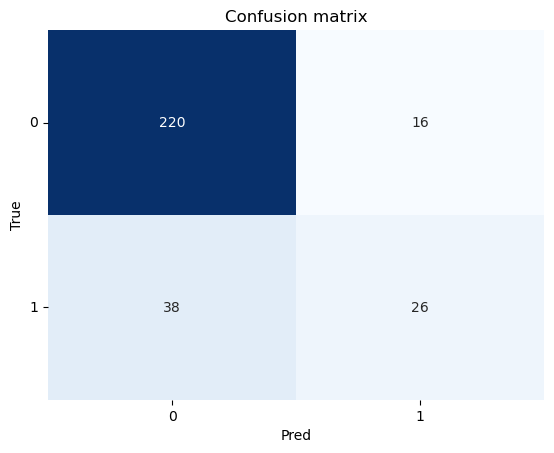

In [58]:
# Evaluating the performance of the validated data
y_pred_clf_tfidf_val, y_score_clf_tfidf_val = evaluate_model(vectorizer_tuned, clf_tuned, X_train_val, y_train_val, X_test, y_test)

#### 3.4.2 Trying our best LGR model with the additional populated data (from ChatGPT3&4).

In [78]:
# Evaluating the performance of the populated data
y_pred_clf_tfidf_pop, y_score_clf_tfidf_pop = evaluate_model(vectorizer_tuned, clf_tuned, X_train_pop, y_train_pop, X_test, y_test)

---------------------------------------
LogisticRegression with TfidfVectorizer
---------------------------------------


,precision,recall,f1-score,support
0,0.885246,0.915254,0.90,236
1,0.642857,0.562500,0.60,64
avg/total,0.760000,0.740000,0.75,300


Accuracy: 84.00%


Wow! it actually increased quite a lot! Cool, let's try to use them both and see what happens.

#### 3.4.3 Trying our best LGR model with the additional populated and validation data.

---------------------------------------
LogisticRegression with TfidfVectorizer
---------------------------------------


,precision,recall,f1-score,support
0,0.875000,0.919492,0.896694,236
1,0.634615,0.515625,0.568966,64
avg/total,0.750000,0.720000,0.730000,300


Accuracy: 83.33%


<Figure size 100x100 with 0 Axes>

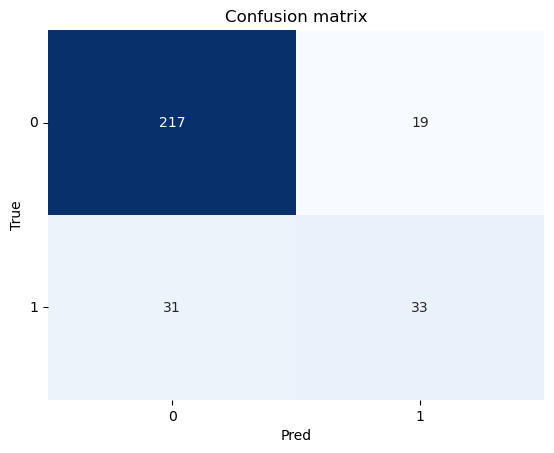

In [61]:
# Evaluating the performance of the populated and validated data
y_pred_clf_tfidf_val_pop, y_score_clf_tfidf_val_pop = evaluate_model(vectorizer_tuned, clf_tuned, X_train_val_pop, y_train_val_pop, X_test, y_test)

Interestingly, the additional training-data from ChatGPT alone, gave the best performance. We used different prompts, asking for info from websites, annual reports and so on, in addition to differ in length. This might have given the model more diversification and robustness, compared to the validation data which might be very similar to the training data.

#### 3.4.4 Trying our best LGR model with populated (ChatGPT3&4) and augmented data


Train set with augmented data


0    3716
1    1335
dtype: int64

---------------------------------------
LogisticRegression with TfidfVectorizer
---------------------------------------


,precision,recall,f1-score,support
0,0.850,0.936441,0.891129,236
1,0.625,0.390625,0.480769,64
avg/total,0.740,0.660000,0.690000,300


Accuracy: 82.00%


<Figure size 100x100 with 0 Axes>

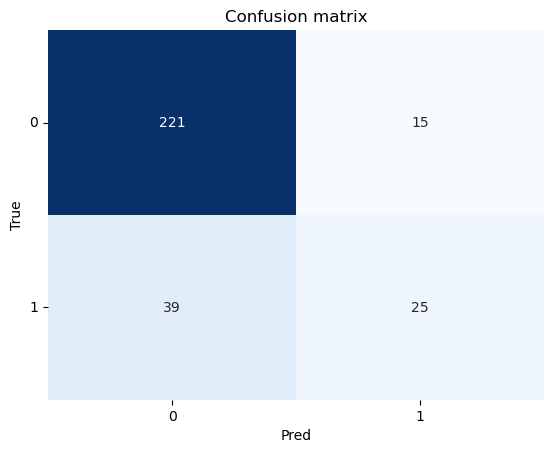

In [63]:
def data_augmentation(sentences, labels, augment_times=1):
    '''
    Function to perform data augmentation
    Input: sentences - list of sentences
           labels - list of labels corresponding to the sentences
           augment_times - number of times to augment each sentence
    Output: aug_sentences - list of augmented sentences
            aug_labels - list of labels for the augmented sentences
    '''
    synonym_aug = naw.SynonymAug(aug_src='wordnet')

    aug_sentences = []
    aug_labels = []

    for i in range(augment_times):
        for sentence, label in zip(sentences, labels):
            # Apply synonym augmentation
            new_sentence = synonym_aug.augment(sentence)

            # Only append the new sentence if it's not NaN
            if pd.notnull(new_sentence):
                aug_sentences.append(new_sentence)
                aug_labels.append(label)

    return aug_sentences, aug_labels


# Feeding the data_augmentation function with the training data
augmented_sentences, augmented_labels = data_augmentation(X_train_pop.values.tolist(), y_train.values.tolist())

# Convert the list of augmented sentences and labels to pandas Series
augmented_sentences = pd.Series(augmented_sentences, index = range(len(X_train_pop), len(X_train_pop) + len(augmented_sentences)))
augmented_labels = pd.Series(augmented_labels, index = range(len(X_train_pop), len(X_train_pop) + len(augmented_labels)))

# Concatenate the augmented sentences and labels with the original training data
X_train_aug = pd.concat([X_train_pop, augmented_sentences])
y_train_aug = pd.concat([y_train_pop, augmented_labels])

# Print the number of observations per class
print(Colors.OKBLUE + "\nTrain set with augmented data" + Colors.ENDC)
display(y_train_aug.value_counts())

# Convert list of words in each document into a single string
X_train_aug = [" ".join(sublist) for sublist in X_train_aug]

# Now we can evaluate the model
y_pred_clf_tfidf_aug, y_score_clf_tfidf_aug = evaluate_model(vectorizer_tuned, clf_tuned, X_train_aug, y_train_aug, X_test, y_test)


#### 3.6 Trying different text embeddings with the fine tuned logistic regression model

In [79]:
# A wrapper for Word2Vec to allow it to be used in a scikit-learn Pipeline
class Word2VecVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, size=100):
        self.size = size
        self.model = None
        
    def fit(self, X, y=None):
        sentences = [doc.split() for doc in X]
        self.model = Word2Vec(sentences, vector_size=self.size, window=5, min_count=1, workers=4)
        return self

    def transform(self, X):
        return np.array([np.mean([self.model.wv[w] for w in doc.split() if w in self.model.wv]
                                or [np.zeros(self.size)], axis=0) for doc in X])

# Now, you can use these vectorizers with the evaluate_model function:

# CountVectorizer
count_vectorizer = CountVectorizer(tokenizer=spacy_tokenizer)
y_pred_c_vec, y_score_c_vec = evaluate_model(count_vectorizer, clf_tuned, X_train, y_train, X_test, y_test)

# HashingVectorizer
hashing_vectorizer = HashingVectorizer(tokenizer=spacy_tokenizer)
y_pred_h_vec, y_score_h_vec = evaluate_model(hashing_vectorizer, clf_tuned, X_train, y_train, X_test, y_test)

# Word2Vec
w2v_vectorizer = Word2VecVectorizer()
y_pred_w2v, y_score_w2v = evaluate_model(w2v_vectorizer, clf_tuned, X_train, y_train, X_test, y_test)


---------------------------------------
LogisticRegression with CountVectorizer
---------------------------------------


,precision,recall,f1-score,support
0,0.882353,0.889831,0.886076,236
1,0.580645,0.562500,0.571429,64
avg/total,0.730000,0.730000,0.730000,300


Accuracy: 82.00%
-----------------------------------------
LogisticRegression with HashingVectorizer
-----------------------------------------


,precision,recall,f1-score,support
0,0.868,0.919492,0.893004,236
1,0.620,0.484375,0.543860,64
avg/total,0.740,0.700000,0.720000,300


Accuracy: 82.67%
------------------------------------------
LogisticRegression with Word2VecVectorizer
------------------------------------------


,precision,recall,f1-score,support
0,0.786667,1.0,0.880597,236
1,0.000000,0.0,0.000000,64
avg/total,0.390000,0.5,0.440000,300


Accuracy: 78.67%


#### 3.7 Comparing Vectorizers

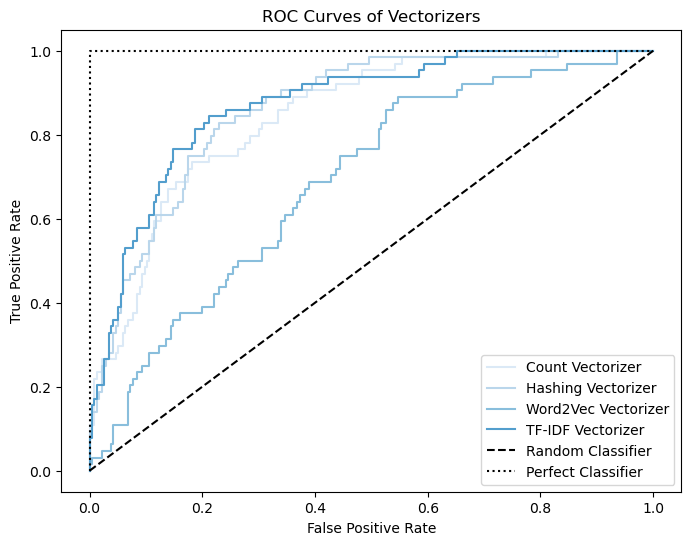

In [93]:
# Create a list of vectorizer names
vectorizer_names = ['Count Vectorizer', 'Hashing Vectorizer', 'Word2Vec Vectorizer', 'TF-IDF Vectorizer']

# Create a list of vectorizer scores
y_scores = [y_score_c_vec, y_score_h_vec, y_score_w2v, y_score_clf_tfidf_pop]

# Comparing the ROC curves of the vectorizers
plt.figure(figsize=(8, 6))

# Plot the ROC curve for each vectorizer
for name, y_score in zip(vectorizer_names, y_scores):
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    plt.plot(fpr, tpr, label=name)

# Plot the ROC curve of a purely random classifier
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

# Plot the ROC curve of a perfect classifier
plt.plot([0, 0, 1], [0, 1, 1], 'k:', label='Perfect Classifier')

# Add labels and legend to the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves of Vectorizers')
plt.legend()
plt.show()


This plot, known as the Receiver Operating Characteristic (ROC) curve, is an important tool for evaluating the performance of binary classifiers. It plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold settings. By comparing different ROC curves, we can make informed decisions about which vectorizer is best suited for our specific task based on its performance in terms of trade-off between sensitivity (TPR) and specificity (1 - FPR).

Each line in the plot corresponds to a different vectorizer. The closer a curve follows the left-hand border and then the top border of the ROC space, the more accurate the test. This means the top left corner of the plot is the 'ideal' point - a false positive rate of zero, and a true positive rate of one. Therefore, a model whose ROC curve is closer to the top left corner performs better than a model whose curve is closer to the diagonal line.

The diagonal line in the middle of the plot represents a random classifier (e.g., a coin flip), which has an equal chance of giving a correct or incorrect classification. Any good classifier should have its ROC curve above this line. If a curve is below this line, it means the classifier is worse than random chance. 

The dotted line represents a perfect classifier.

In conclusion, this ROC curve comparison plot is useful because it provides a comprehensive visual representation of how well each vectorizer performs as a classifier, considering both types of errors (false positives and false negatives).

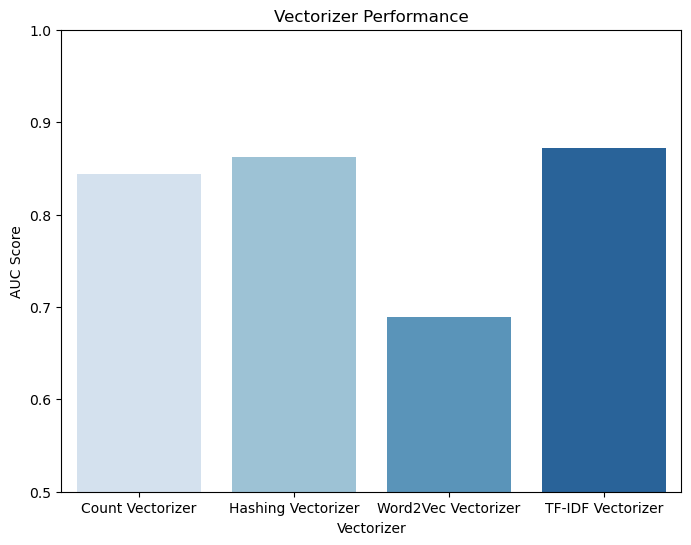

In [91]:

# Create a list of vectorizer predictions
y_preds = [y_pred_c_vec, y_pred_h_vec, y_pred_w2v, y_pred_clf_tfidf_pop]

# Create a list of vectorizer AUC scores
auc_scores = [roc_auc_score(y_test, y_score) for y_score in y_scores]

# Create a DataFrame of vectorizer performance
vectorizer_performance = pd.DataFrame(
    {'Vectorizer': vectorizer_names, 'AUC Score': auc_scores})

# Plot the performance of the vectorizers as a bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x='Vectorizer', y='AUC Score', data=vectorizer_performance,
            palette='Blues')  # AUC = Area Under the Curve (ROC)
plt.title('Vectorizer Performance')
plt.ylim(0.5, 1)
plt.show()


The bar chart provided offers a visual comparison of the performance of different vectorizers used in our text classification model, as measured by the Area Under the Curve (AUC) of the Receiver Operating Characteristic (ROC) curve. AUC-ROC is a valuable metric for this purpose, as it provides a comprehensive view of model performance across all possible classification thresholds, unlike accuracy, precision, or recall which depend on a specific threshold. An AUC-ROC score close to 1.0 indicates that the model has a high ability to distinguish between the classes correctly, regardless of the threshold chosen. Therefore, in this graph, the TF-IDF vectorizer is the one that, on average, best discriminates between the classes in our dataset.

## Environment description

In [ ]:
%load_ext watermark
%watermark -v -p pandas,numpy,sklearn,datasets,spacy,wordcloud

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.12.0

pandas   : 1.4.3
numpy    : 1.21.5
sklearn  : 1.2.1
datasets : 2.11.0
spacy    : 3.5.2
wordcloud: 1.8.2.2

